In [7]:
# If needed, install helpers
!pip install gdown --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)


In [11]:
from google.colab import files

uploaded = files.upload()



Saving fear_greed_index.csv to fear_greed_index.csv
Saving historical_data.csv to historical_data.csv


In [12]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

trades.head(), sentiment.head()


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

In [13]:
# Convert Timestamp IST to datetime (from Hyperliquid data)
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

# Remove rows where timestamp conversion failed
trades = trades.dropna(subset=['Timestamp IST'])

# Create a date column to match sentiment data
trades['date'] = trades['Timestamp IST'].dt.date

# Fix sentiment date column format
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

trades[['Timestamp IST', 'date']].head()


,Timestamp IST,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [14]:
df = trades.merge(sentiment[['date', 'classification']], on='date', how='left')

# Rename for clarity
df = df.rename(columns={'classification': 'sentiment'})

df[['Coin', 'Side', 'Closed PnL', 'sentiment']].head()


,Coin,Side,Closed PnL,sentiment
0,@107,BUY,0.0,Extreme Greed
1,@107,BUY,0.0,Extreme Greed
2,@107,BUY,0.0,Extreme Greed
3,@107,BUY,0.0,Extreme Greed
4,@107,BUY,0.0,Extreme Greed


In [15]:
# Profit
df['profit'] = df['Closed PnL']

# Win or loss label
df['win'] = (df['profit'] > 0).astype(int)

# Position direction (1 = Long, 0 = Short)
df['is_long'] = df['Side'].str.upper().map({'BUY': 1, 'SELL': 0})

# ROI percentage based on Size USD
df['roi_pct'] = np.where(df['Size USD'] > 0,
                         (df['profit'] / df['Size USD']) * 100,
                         np.nan)

# Time-based features
df['day_of_week'] = df['Timestamp IST'].dt.day_name()
df['hour'] = df['Timestamp IST'].dt.hour

df[['profit', 'win', 'is_long', 'roi_pct', 'day_of_week', 'hour']].head()


,profit,win,is_long,roi_pct,day_of_week,hour
0,0.0,0,1,0.0,Monday,22
1,0.0,0,1,0.0,Monday,22
2,0.0,0,1,0.0,Monday,22
3,0.0,0,1,0.0,Monday,22
4,0.0,0,1,0.0,Monday,22


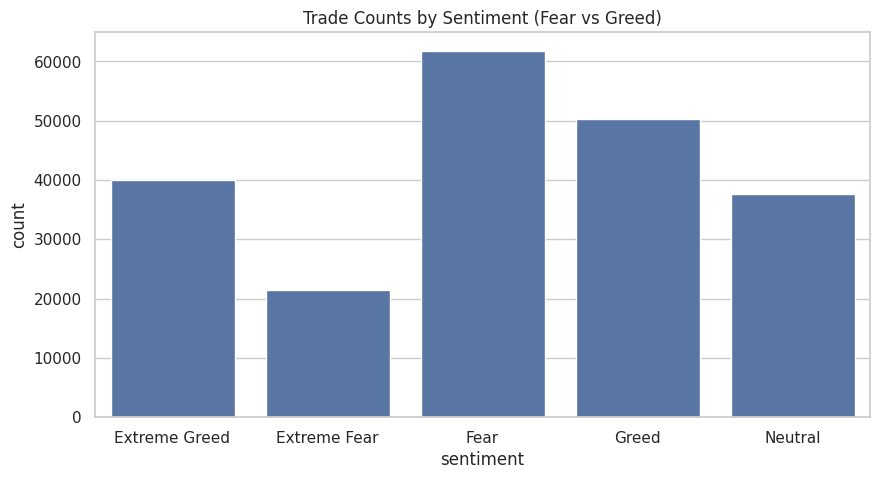

In [16]:
sns.countplot(data=df, x='sentiment')
plt.title("Trade Counts by Sentiment (Fear vs Greed)")
plt.show()


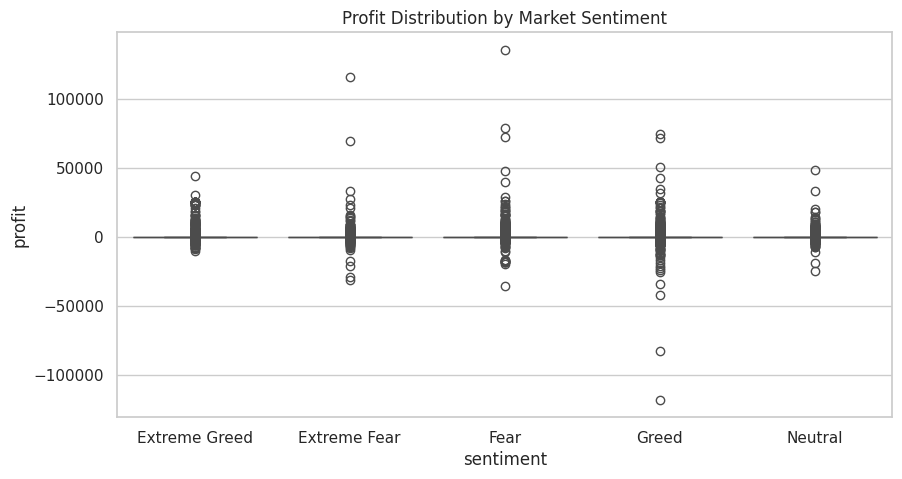

In [17]:
sns.boxplot(data=df, x='sentiment', y='profit')
plt.title("Profit Distribution by Market Sentiment")
plt.show()


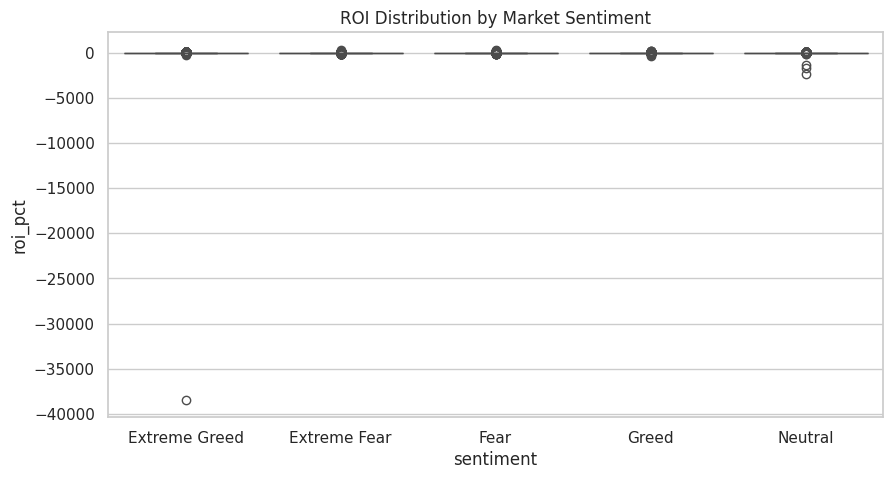

In [18]:
sns.boxplot(data=df, x='sentiment', y='roi_pct')
plt.title("ROI Distribution by Market Sentiment")
plt.show()


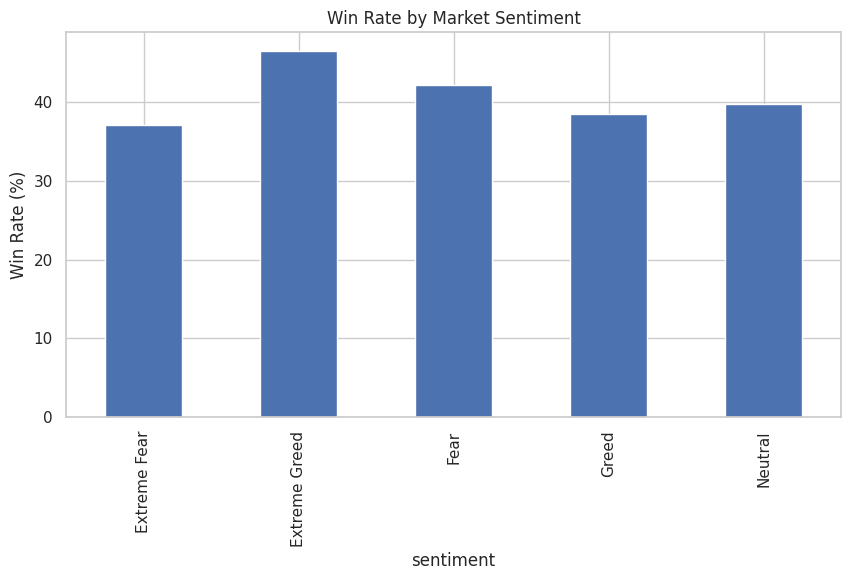

,win
sentiment,
Extreme Fear,37.060748
Extreme Greed,46.494299
Fear,42.076750
Greed,38.482794
Neutral,39.699093


In [19]:
win_rate = df.groupby('sentiment')['win'].mean() * 100
win_rate.plot(kind='bar')
plt.ylabel("Win Rate (%)")
plt.title("Win Rate by Market Sentiment")
plt.show()

win_rate


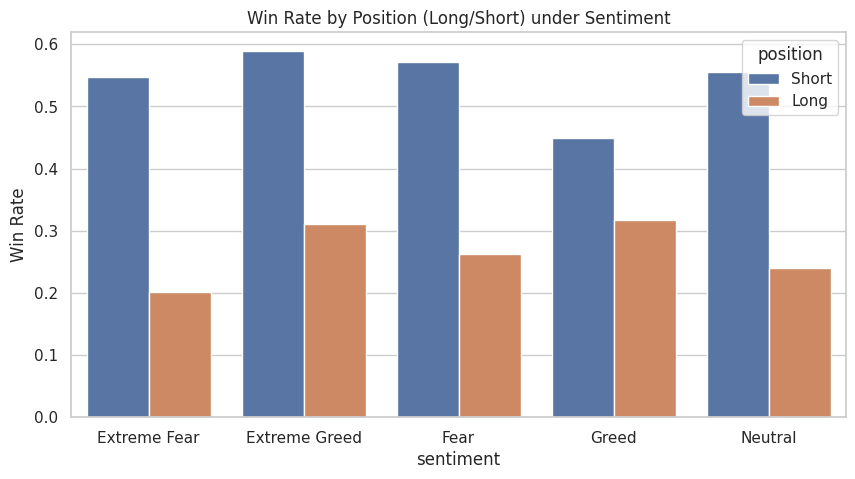

In [20]:
ls = df.groupby(['sentiment', 'is_long'])['win'].mean().reset_index()
ls['position'] = ls['is_long'].map({1:'Long', 0:'Short'})

sns.barplot(data=ls, x='sentiment', y='win', hue='position')
plt.title("Win Rate by Position (Long/Short) under Sentiment")
plt.ylabel("Win Rate")
plt.show()


In [21]:
strategy = (
    ((df['sentiment'].str.contains("Greed", case=False)) & (df['is_long'] == 1)) |
    ((df['sentiment'].str.contains("Fear", case=False)) & (df['is_long'] == 0))
)

strategy_df = df[strategy]

baseline = df['win'].mean() * 100
strategy_win = strategy_df['win'].mean() * 100

print("Baseline Win Rate: ", baseline)
print("Strategy Win Rate (Long Greed, Short Fear): ", strategy_win)


Baseline Win Rate:  41.12648183918494
Strategy Win Rate (Long Greed, Short Fear):  43.98448218763306


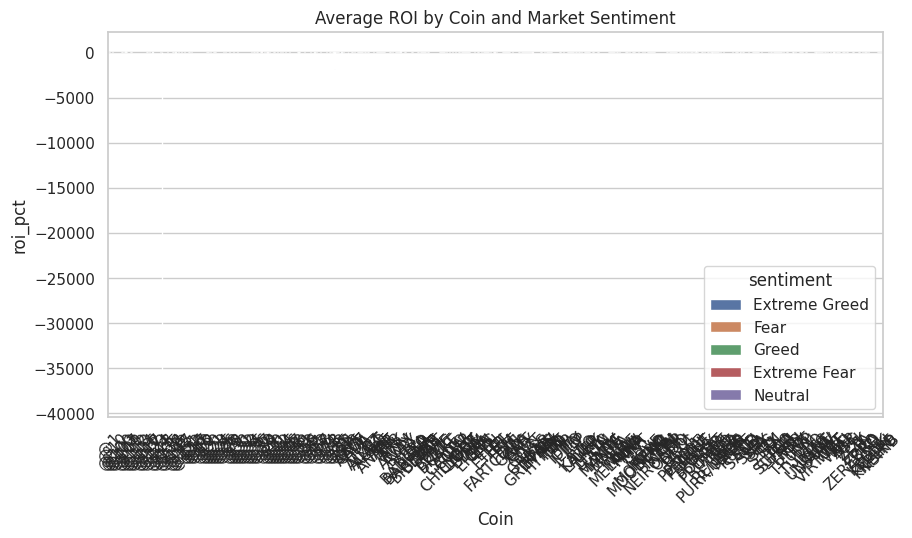

In [22]:
coin_perf = df.groupby(['Coin', 'sentiment'])['roi_pct'].mean().reset_index()

sns.barplot(data=coin_perf, x='Coin', y='roi_pct', hue='sentiment')
plt.title("Average ROI by Coin and Market Sentiment")
plt.xticks(rotation=45)
plt.show()


In [23]:
#model (aditional)
ml_df = df.dropna(subset=['win', 'roi_pct', 'is_long'])

X = ml_df[['roi_pct', 'is_long', 'Coin', 'sentiment']]
y = ml_df['win']

categorical = ['Coin', 'sentiment']
numeric = ['roi_pct', 'is_long']

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numeric)
])

model = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
pred = model.predict(X_test)

print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24768
           1       1.00      1.00      1.00     17469

    accuracy                           1.00     42237
   macro avg       1.00      1.00      1.00     42237
weighted avg       1.00      1.00      1.00     42237

[[24768     0]
 [    1 17468]]


In [24]:
ohe = model.named_steps['prep'].named_transformers_['cat']
cat_features = list(ohe.get_feature_names_out(['Coin', 'sentiment']))
num_features = ['roi_pct', 'is_long']
all_features = cat_features + num_features

importances = model.named_steps['clf'].feature_importances_

feat_imp = pd.DataFrame({'feature': all_features, 'importance': importances})
feat_imp.sort_values('importance', ascending=False).head(10)


,feature,importance
245,roi_pct,0.884570
246,is_long,0.051568
4,Coin_@107,0.011052
155,Coin_MELANIA,0.006326
132,Coin_HYPE,0.003177
117,Coin_FARTCOIN,0.002623
242,sentiment_Greed,0.002231
121,Coin_FTT,0.001927
100,Coin_BTC,0.001843
115,Coin_ETH,0.001821
